In [1]:
import pandas as pd
import numpy as np
import scipy
import joblib
from tqdm import tqdm

import matplotlib.pylab as plt
import matplotlib
import seaborn as sns
DEVICE="cpu"
sns.set_style()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Rubik"
sns.set_context("paper")
%matplotlib ipympl
plt.ioff()

/tmp/ipykernel_2149604/1652960386.py:13: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)


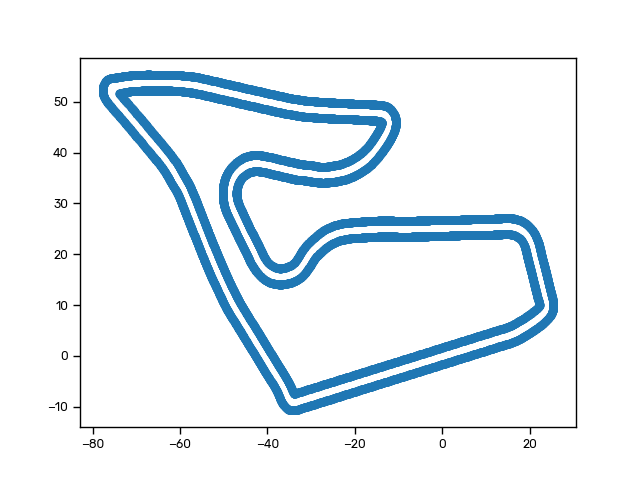

In [2]:
from PIL import Image
import yaml
def _get_map_points(map_path, map_ext):
    with open(map_path + '.yaml', 'r') as yaml_stream:
        try:
            map_metadata = yaml.safe_load(yaml_stream)
            map_resolution = map_metadata['resolution']
            origin = map_metadata['origin']
            origin_x = origin[0]
            origin_y = origin[1]
        except yaml.YAMLError as ex:
            print(ex)
    map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)
    map_height = map_img.shape[0]
    map_width = map_img.shape[1]

    # convert map pixels to coordinates
    range_x = np.arange(map_width)
    range_y = np.arange(map_height)
    map_x, map_y = np.meshgrid(range_x, range_y)
    map_x = (map_x * map_resolution + origin_x).flatten()
    map_y = (map_y * map_resolution + origin_y).flatten()
    map_z = np.zeros(map_y.shape)
    map_coords = np.vstack((map_x, map_y, map_z))

    # mask and only leave the obstacle points
    map_mask = map_img == 0.0
    map_mask_flat = map_mask.flatten()
    map_points = map_coords[:, map_mask_flat].T
    return map_points[:,0], map_points[:,1]

map_x, map_y = _get_map_points("track_config/Spielberg_map", ".png")
plt.scatter(map_x, map_y)
plt.show()

In [3]:
traces = list()
trace_names = list()
trace_speeds = list()
trace_lines = list()
with tqdm(total=(2*4*3)) as pbar:
    for controller in ['stanley', 'pure_pursuit']:
        for line in ["center", "left", "right", "race"]:
            for speed in [0.75, 0.85, 1.0]:
                traces.append(joblib.load(f"../../data/{line}_{speed}_{controller}trace.pkl"))
                trace_names.append(f"{line} @ {speed} - {controller}")
                trace_speeds.append(speed)
                trace_lines.append(line)
                pbar.update()

100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [03:12<00:00,  8.01s/it]


In [4]:
print([len(trace) for trace in traces])
print(len(traces))

[24969, 24969, 24969, 25443, 25443, 25443, 24491, 24491, 24491, 22547, 22547, 22547, 24969, 24969, 24969, 25443, 25443, 25443, 24491, 24491, 24491, 22547, 22547, 22547]
24


In [5]:
START_IDX=6
end_indices = list()
for trace in traces:
    progs = np.array([pack['opp_prog'] for pack in trace])
    end_indices.append(np.argmax(progs>(2000+progs[START_IDX])))

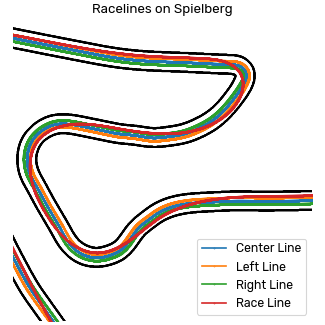

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [71]:
plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(3.25,3.25), constrained_layout=True)

ax.scatter(map_x, map_y, [1 for _ in range(len(map_y))], marker='.', color='black')
for i in [0, 3, 6, 9]:
    ax.plot([pack['opp_x'] for pack in traces[i][START_IDX+100:end_indices[i]]], [pack['opp_y'] for pack in traces[i][START_IDX+100:end_indices[i]]], marker='.', markersize=0.5, label=f"{trace_lines[i].capitalize()} Line")
ax.set_aspect('equal')
ax.axis('off')
ax.set_xlim([-51, -1])
ax.set_ylim([5, 55])
ax.legend()
ax.set_title("Racelines on Spielberg")
plt.show()
fig.savefig("../approaches/plotting/track_image.eps", bbox_inches='tight')

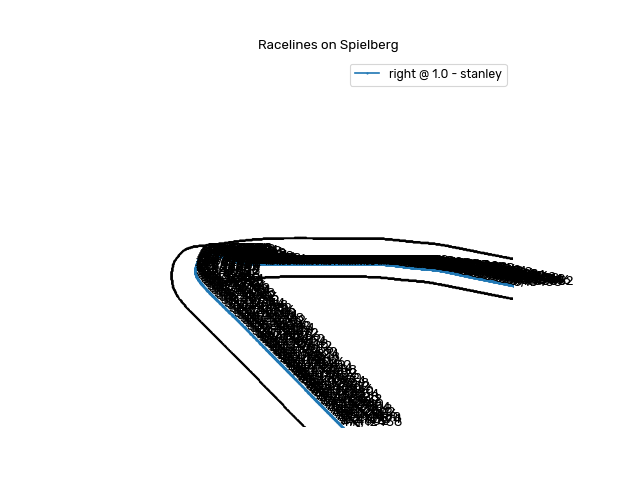

In [16]:
plt.close('all')
plt.scatter(map_x, map_y, [1 for _ in range(len(map_y))], marker='.', color='black')
IDX=8
for i in [IDX]:
    plt.plot([pack['opp_x'] for pack in traces[i][START_IDX:end_indices[i]]], [pack['opp_y'] for pack in traces[i][START_IDX:end_indices[i]]], marker='.', markersize=1, label=trace_names[i])
for i in range(0, int(end_indices[IDX]), 6):
    plt.annotate(f"{traces[IDX][i]['opp_prog']%600:d},{i}", (traces[IDX][i]['opp_x'], traces[IDX][i]['opp_y']))
plt.gca().set_aspect('equal')
plt.axis('off')
plt.xlim([-80, -50])
plt.ylim([40, 70])
plt.legend()
plt.title("Racelines on Spielberg")
plt.show()

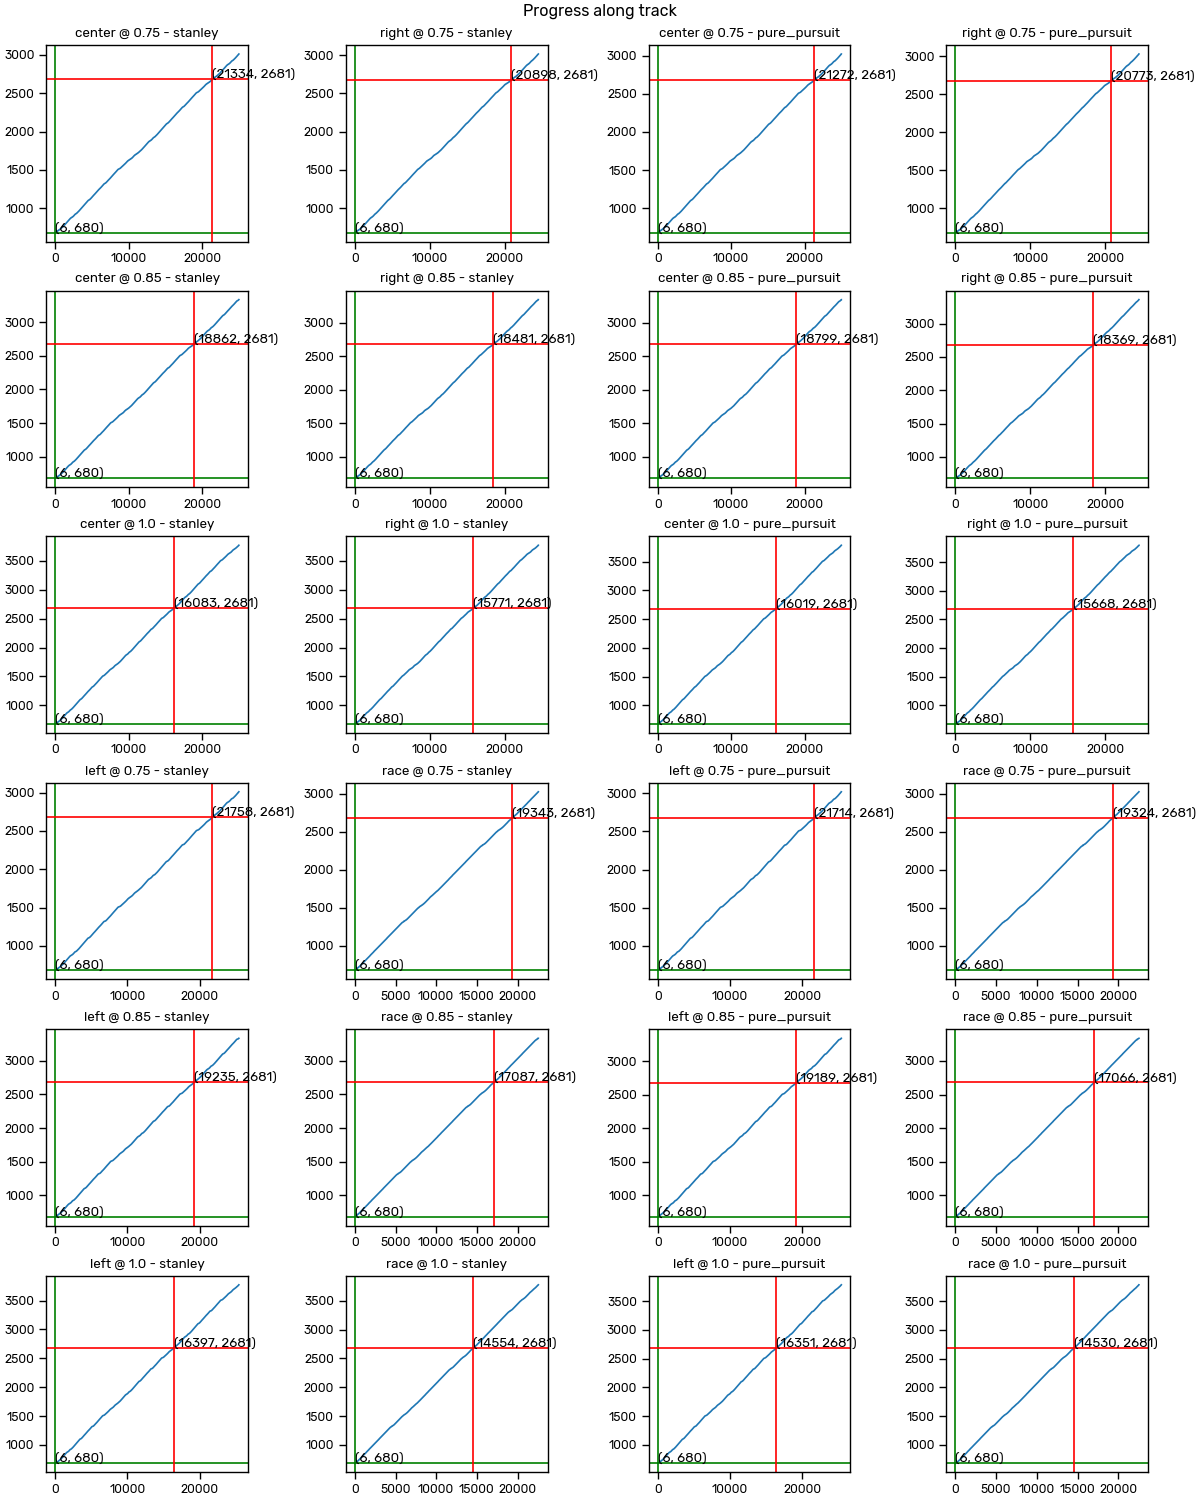

In [17]:
plt.close('all')
fig, axs = plt.subplots(6, 4, figsize=(12,15), constrained_layout=True)
for i in range(len(traces)):
    axs[i%6,i//6].plot([pack['opp_prog'] for pack in traces[i][:]])
    axs[i%6,i//6].axvline(x=START_IDX, color='green')
    axs[i%6,i//6].axhline(y=traces[i][START_IDX]['opp_prog'], color='green')
    axs[i%6,i//6].annotate((START_IDX, traces[i][START_IDX]['opp_prog']), (START_IDX, traces[i][START_IDX]['opp_prog']))
    axs[i%6,i//6].axvline(x=end_indices[i], color='red')
    axs[i%6,i//6].axhline(y=traces[i][end_indices[i]]['opp_prog'], color='red')
    axs[i%6,i//6].annotate((end_indices[i], traces[i][end_indices[i]]['opp_prog']), (end_indices[i], traces[i][end_indices[i]]['opp_prog']))
    axs[i%6,i//6].set_title(trace_names[i])
fig.suptitle("Progress along track")
plt.show()

In [18]:
def _range(steering_values):
    return np.max(steering_values)-np.min(steering_values)

In [19]:
dataset = list()

In [20]:
STEP_LENGTH = 10 # TODO: Not implemented
NOISE_STD_DEV = 0.01
INPUT_LENGTH = 10
HORIZON = 60
for trace_idx, trace in tqdm(enumerate([trace[START_IDX:end_indices[i]] for i, trace in enumerate(traces)])):
    for i in range(15, (len(trace)-HORIZON)//INPUT_LENGTH):
        data_item = {
            'input': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta'], trace[idx]['opp_deflection'], *trace[idx]['opp_forward_curvature']] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))], dtype=np.float32),
            'input_vel': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta'], trace[idx]['opp_vel'], trace[idx]['opp_deflection'], *trace[idx]['opp_forward_curvature']] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))], dtype=np.float32),
            'input_no_curve': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta']] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))], dtype=np.float32),
            'last_pose': np.array([trace[(i*INPUT_LENGTH)+(INPUT_LENGTH-1)]['opp_x'], trace[(i*INPUT_LENGTH)+(INPUT_LENGTH-1)]['opp_y'], trace[(i*INPUT_LENGTH)+(INPUT_LENGTH-1)]['opp_theta'], trace[(i*INPUT_LENGTH)+(INPUT_LENGTH-1)]['opp_vel']]),
            'steering_range': _range([trace[idx]['opp_steer'] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))]),
            'max_steering': np.max([trace[idx]['opp_steer'] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))]),
            'min_steering': np.min([trace[idx]['opp_steer'] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))]),
            'curvature_range': _range([trace[idx]['opp_forward_curvature'][0] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))]),
            'max_curvature': np.max([trace[idx]['opp_forward_curvature'][0] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))]),
            'min_curvature': np.min([trace[idx]['opp_forward_curvature'][0] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))]),
            'avg_curvature': np.mean([trace[idx]['opp_forward_curvature'][0] for idx in range(i*INPUT_LENGTH,((i+1)*INPUT_LENGTH))]),
            'target': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta']] for idx in range(((i+1)*INPUT_LENGTH),(i+1)*INPUT_LENGTH+HORIZON)]),
            'selected_lane': trace[0]['selected_lane'],
            'trace_name': trace_names[trace_idx],
            'controller': trace[0]['opp_controller'],
            'trace_speed': trace_speeds[trace_idx]
        }
        """
        rand_nums = np.random.normal(0, NOISE_STD_DEV, (INPUT_LENGTH-1,4))
        data_item['input'][:-1,:4] += rand_nums
        data_item['input_vel'][:-1,:4] += rand_nums
        data_item['input_no_curve'][:-1,:3] += rand_nums[:,:3]
        """
        dataset.append(data_item)
        
        

24it [00:07,  3.17it/s]


In [75]:
dataset[0]['input'][0]

array([-41.077866  ,  17.358068  ,   5.4836698 ,  -0.04888063,
         0.6082615 ,   0.59982854,   0.6988223 ,  -0.14561068,
        -0.11017358], dtype=float32)

In [22]:
dataset_frame = pd.DataFrame(dataset)

In [23]:
dataset_frame

,input,input_vel,input_no_curve,last_pose,steering_range,max_steering,min_steering,curvature_range,max_curvature,min_curvature,avg_curvature,target,selected_lane,trace_name,controller,trace_speed
0,"[[-41.077866, 17.358068, 5.4836698, -0.0488806...","[[-41.077866, 17.358068, 5.4836698, 2.525476, ...","[[-41.077866, 17.358068, 5.4836698], [-41.0601...","[-40.91731671683274, 17.20233414229849, 5.5238...",0.035969,0.078926,0.042957,0.000000,0.608262,0.608262,0.608262,"[[-40.8992808691125, 17.185565757488785, 5.527...",center,center @ 0.75 - stanley,stanley,0.75
1,"[[-40.89928, 17.185566, 5.527619, -0.28277713,...","[[-40.89928, 17.185566, 5.527619, 2.461629, -0...","[[-40.89928, 17.185566, 5.527619], [-40.88119,...","[-40.73618143703475, 17.03882610502019, 5.5581...",0.048748,0.074553,0.025805,0.006743,0.615005,0.608262,0.612982,"[[-40.71791512438244, 17.023184205183174, 5.56...",center,center @ 0.75 - stanley,stanley,0.75
2,"[[-40.717915, 17.023184, 5.563313, -0.18257344...","[[-40.717915, 17.023184, 5.563313, 2.4029515, ...","[[-40.717915, 17.023184, 5.563313], [-40.69960...","[-40.552184133402484, 16.885767903898365, 5.59...",0.050664,0.077482,0.026818,0.005782,0.620787,0.615005,0.616739,"[[-40.53376638502092, 16.870851983406226, 5.59...",center,center @ 0.75 - stanley,stanley,0.75
3,"[[-40.533768, 16.870852, 5.597867, -0.08132341...","[[-40.533768, 16.870852, 5.597867, 2.3668783, ...","[[-40.533768, 16.870852, 5.597867], [-40.51531...","[-40.36554739896374, 16.742365526829268, 5.638...",0.038154,0.073988,0.035834,0.000000,0.620787,0.620787,0.620787,"[[-40.34664431392212, 16.728509357053944, 5.64...",center,center @ 0.75 - stanley,stanley,0.75
4,"[[-40.346645, 16.72851, 5.6417017, -0.30925485...","[[-40.346645, 16.72851, 5.6417017, 2.343378, -...","[[-40.346645, 16.72851, 5.6417017], [-40.32769...","[-40.1761651240786, 16.60645313352535, 5.66659...",0.053870,0.076472,0.022601,0.007245,0.628032,0.620787,0.626583,"[[-40.15703524818328, 16.593413690478705, 5.67...",center,center @ 0.75 - stanley,stanley,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43353,"[[-46.446827, 24.580936, 5.2008877, -0.8179011...","[[-46.446827, 24.580936, 5.2008877, 4.2740483,...","[[-46.446827, 24.580936, 5.2008877], [-46.4270...","[-46.265278436323634, 24.24011365564182, 5.216...",0.005760,0.020216,0.014455,0.010168,0.030474,0.020305,0.028440,"[[-46.24466229234019, 24.202248750536818, 5.21...",race,race @ 1.0 - pure_pursuit,pure_pursuit,1.00
43354,"[[-46.244663, 24.20225, 5.21811, -0.83270276, ...","[[-46.244663, 24.20225, 5.21811, 4.3132796, -0...","[[-46.244663, 24.20225, 5.21811], [-46.223972,...","[-46.055338824372505, 23.861545900854882, 5.23...",0.006595,0.016530,0.009935,0.010177,0.020305,0.010129,0.016235,"[[-46.03385242857241, 23.823675677056134, 5.23...",race,race @ 1.0 - pure_pursuit,pure_pursuit,1.00
43355,"[[-46.03385, 23.823675, 5.2355375, -0.8516381,...","[[-46.03385, 23.823675, 5.2355375, 4.3566566, ...","[[-46.03385, 23.823675, 5.2355375], [-46.01228...","[-45.83656086412874, 23.482752834371833, 5.251...",0.008048,0.011240,0.003192,0.010165,0.010129,-0.000037,0.004030,"[[-45.81418566932404, 23.444865210325876, 5.25...",race,race @ 1.0 - pure_pursuit,pure_pursuit,1.00
43356,"[[-45.814186, 23.444864, 5.2530756, -0.8754787...","[[-45.814186, 23.444864, 5.2530756, 4.402759, ...","[[-45.814186, 23.444864, 5.2530756], [-45.7917...","[-45.60907608754187, 23.103613328316968, 5.265...",0.007382,0.002492,-0.004890,0.010160,-0.000037,-0.010197,-0.008165,"[[-45.58601936371088, 23.0655570822697, 5.2648...",race,race @ 1.0 - pure_pursuit,pure_pursuit,1.00


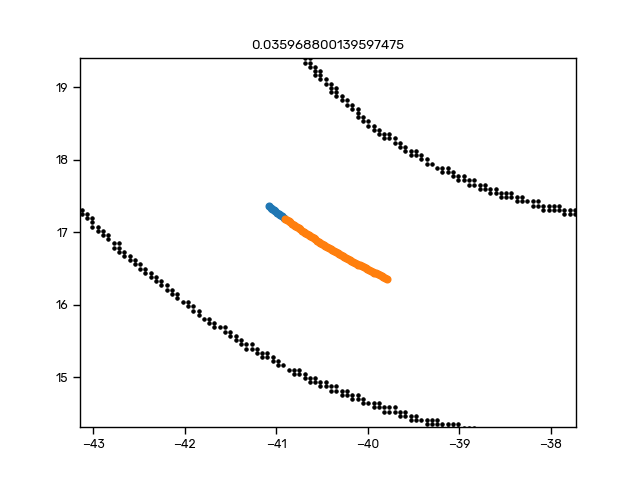

In [24]:
plt.close('all')
DATA_IDX = 0
plt.plot(dataset_frame.iloc[DATA_IDX]['input_vel'][:,0], dataset_frame.iloc[DATA_IDX]['input_vel'][:,1], marker='o')
plt.plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='o')
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.scatter(map_x, map_y, marker=".", color='black')
plt.gca().set_xlim((xlim[0]-2,xlim[1]+2))
plt.gca().set_ylim((ylim[0]-2,ylim[1]+2))
plt.title(dataset_frame.iloc[DATA_IDX]['steering_range'])
plt.show()

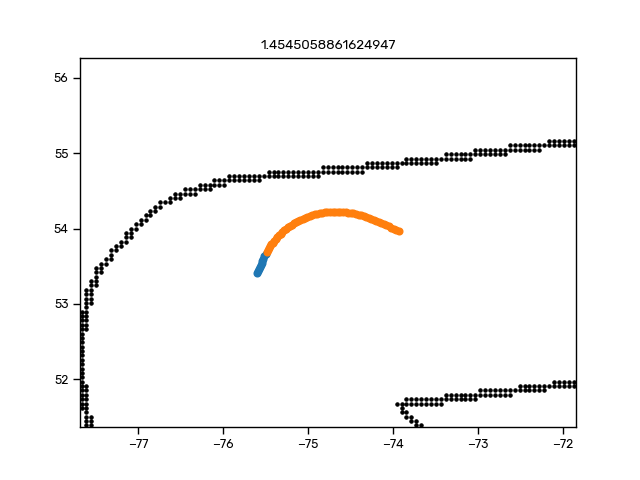

In [25]:
plt.close('all')
DATA_IDX = dataset_frame['steering_range'].idxmax()
plt.plot(dataset_frame.iloc[DATA_IDX]['input_vel'][:,0], dataset_frame.iloc[DATA_IDX]['input_vel'][:,1], marker='o')
plt.plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='o')
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.scatter(map_x, map_y, marker=".", color='black')
plt.gca().set_xlim((xlim[0]-2,xlim[1]+2))
plt.gca().set_ylim((ylim[0]-2,ylim[1]+2))
plt.title(dataset_frame.iloc[DATA_IDX]['steering_range'])
plt.show()

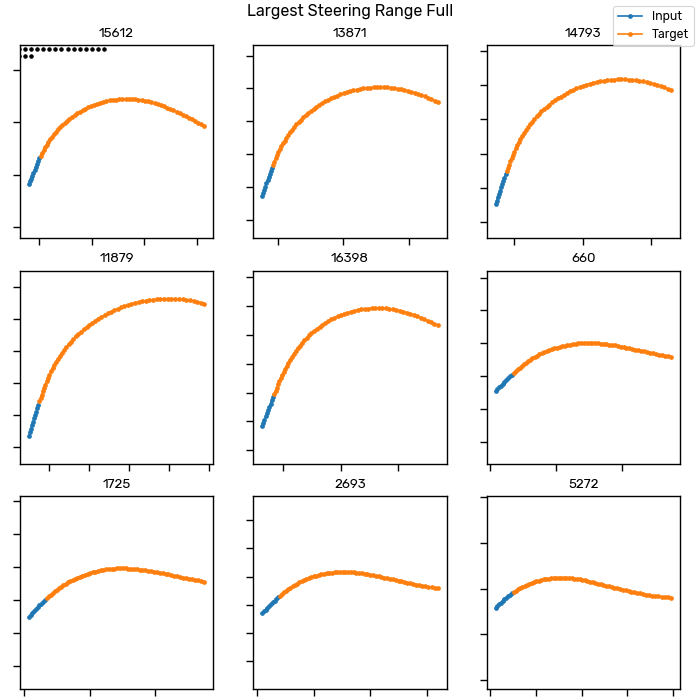

In [26]:
plt.close('all')
fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
for idx, DATA_IDX in enumerate(dataset_frame['steering_range'].sort_values(ascending=False).index[:10][:9]):
    linput, = axs[idx // 3, idx % 3].plot(dataset_frame.iloc[DATA_IDX]['input_vel'][:, 0],
                                          dataset_frame.iloc[DATA_IDX]['input_vel'][:, 1], marker='.', label="Input")
    ltarget, = axs[idx // 3, idx % 3].plot(dataset_frame.iloc[DATA_IDX]['target'][:, 0],
                                           dataset_frame.iloc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
    xlim, ylim = axs[idx // 3, idx % 3].get_xlim(), axs[idx // 3, idx % 3].get_ylim()
    max_lim_range = max(xlim[1]-xlim[0], ylim[1]-ylim[0])
    xlim, ylim = (np.average(xlim)-max_lim_range/2, np.average(xlim)+max_lim_range/2), (np.average(ylim)-max_lim_range/2, np.average(ylim)+max_lim_range/2)
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=xlim,
                               ylim=ylim,
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
    axs[idx // 3, idx % 3].set_title("{}".format(DATA_IDX))
fig.suptitle("Largest Steering Range Full")
fig.legend(handles=[linput, ltarget])
fig.show()

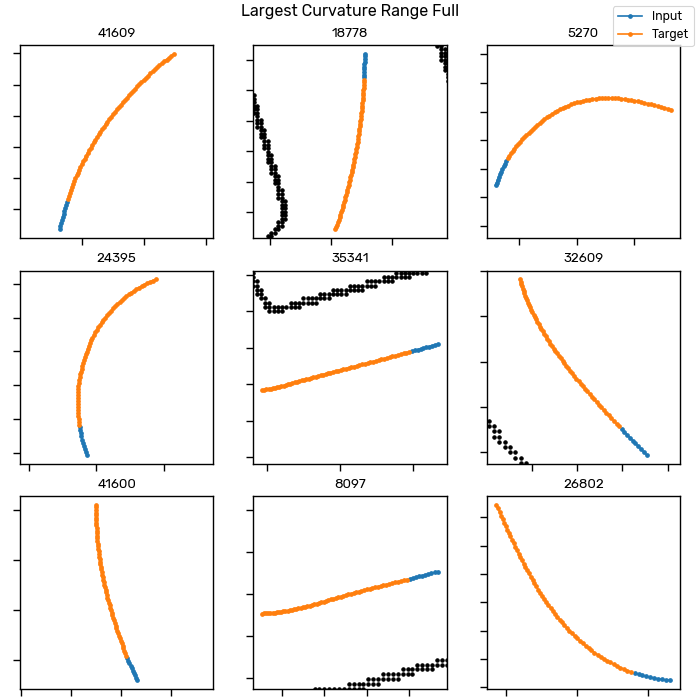

In [27]:
fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
for idx, DATA_IDX in enumerate(dataset_frame['curvature_range'].sort_values(ascending=False).index[::60][:9]):
    linput, = axs[idx//3, idx%3].plot(dataset_frame.iloc[DATA_IDX]['input_vel'][:,0], dataset_frame.iloc[DATA_IDX]['input_vel'][:,1], marker='.', label="Input")
    ltarget, = axs[idx//3, idx%3].plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='.', label="Target")
    xlim, ylim = axs[idx // 3, idx % 3].get_xlim(), axs[idx // 3, idx % 3].get_ylim()
    max_lim_range = max(xlim[1]-xlim[0], ylim[1]-ylim[0])
    xlim, ylim = (np.average(xlim)-max_lim_range/2, np.average(xlim)+max_lim_range/2), (np.average(ylim)-max_lim_range/2, np.average(ylim)+max_lim_range/2)
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=xlim,
                               ylim=ylim,
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
    axs[idx//3, idx%3].set_title("{}".format(DATA_IDX))
fig.suptitle("Largest Curvature Range Full")
fig.legend(handles=[linput, ltarget])
fig.show()

In [28]:
dataset_frame.iloc[DATA_IDX]['input_vel'][:,0]

array([-34.340458, -34.369293, -34.3979  , -34.426285, -34.454456,
       -34.48243 , -34.510212, -34.5378  , -34.565002, -34.591652],
      dtype=float32)

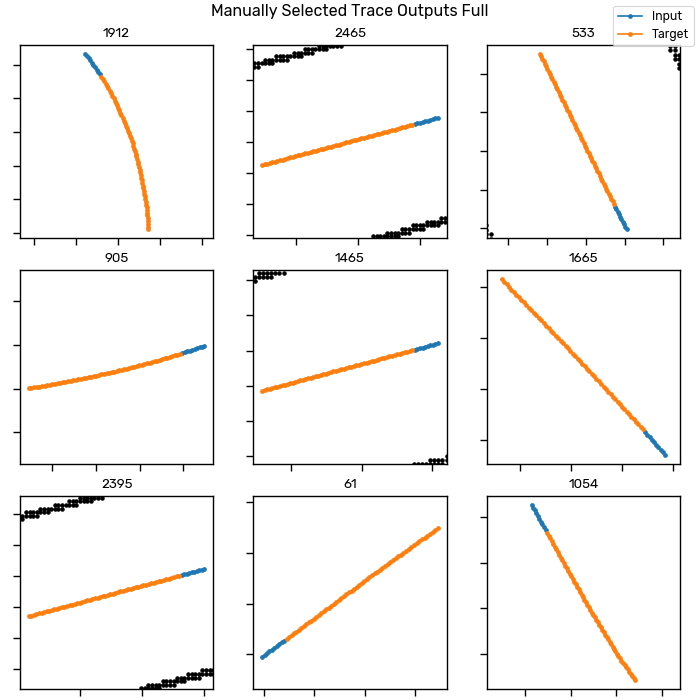

In [29]:
fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
for idx, DATA_IDX in enumerate([1912, 2465, 533, 905, 1465, 1665, 2395, 61, 1054]):
    linput, = axs[idx//3, idx%3].plot(dataset_frame.iloc[DATA_IDX]['input_vel'][:,0], dataset_frame.iloc[DATA_IDX]['input_vel'][:,1], marker='.', label="Input")
    ltarget, = axs[idx//3, idx%3].plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='.', label="Target")
    xlim, ylim = axs[idx // 3, idx % 3].get_xlim(), axs[idx // 3, idx % 3].get_ylim()
    max_lim_range = max(xlim[1]-xlim[0], ylim[1]-ylim[0])
    xlim, ylim = (np.average(xlim)-max_lim_range/2, np.average(xlim)+max_lim_range/2), (np.average(ylim)-max_lim_range/2, np.average(ylim)+max_lim_range/2)
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=xlim,
                               ylim=ylim,
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
    axs[idx//3, idx%3].set_title("{}".format(DATA_IDX))
fig.suptitle("Manually Selected Trace Outputs Full")
fig.legend(handles=[linput, ltarget])
fig.show()

In [30]:
dataset_frame.to_pickle("../../data/final_data.pkl")

In [31]:
from sklearn.model_selection import train_test_split
TEST_FRAC = 0.1
VAL_FRAC = 1/9
classes = dataset_frame['trace_name']
train_frame, test_frame = train_test_split(dataset_frame, stratify=classes, test_size=TEST_FRAC, random_state=1337)
train_frame, val_frame = train_test_split(train_frame, stratify=train_frame['trace_name'], test_size=VAL_FRAC, random_state=1337)

In [32]:
print(f"Total points: {len(train_frame)}")
train_frame.groupby(['selected_lane', 'controller', 'trace_speed']).count()

Total points: 34686


input  input_vel  input_no_curve  \
selected_lane controller   trace_speed                                     
center        pure_pursuit 0.75          1684       1684            1684   
                           0.85          1486       1486            1486   
                           1.00          1264       1264            1264   
              stanley      0.75          1689       1689            1689   
                           0.85          1492       1492            1492   
                           1.00          1268       1268            1268   
left          pure_pursuit 0.75          1719       1719            1719   
                           0.85          1517       1517            1517   
                           1.00          1291       1291            1291   
              stanley      0.75          1724       1724            1724   
                           0.85          1521       1521            1521   
                           1.00          1294       1294            1294   
race          pure_pursuit 0.75          1528       1528            1528   
                           0.85          1348       1348            1348   
                           1.00          1145       1145            1145   
              stanley      0.75          1530       1530            1530   
                           0.85          1349       1349            1349   
                           1.00          1147       1147            1147   
right         pure_pursuit 0.75          1644       1644            1644   
                           0.85          1452       1452            1452   
                           1.00          1236       1236            1236   
              stanley      0.75          1654       1654            1654   
                           0.85          1460       1460            1460   
                           1.00          1244       1244            1244   

                                        last_pose  steering_range  \
selected_lane controller   trace_speed                              
center        pure_pursuit 0.75              1684            1684   
                           0.85              1486            1486   
                           1.00              1264            1264   
              stanley      0.75              1689            1689   
                           0.85              1492            1492   
                           1.00              1268            1268   
left          pure_pursuit 0.75              1719            1719   
                           0.85              1517            1517   
                           1.00              1291            1291   
              stanley      0.75              1724            1724   
                           0.85              1521            1521   
                           1.00              1294            1294   
race          pure_pursuit 0.75              1528            1528   
                           0.85              1348            1348   
                           1.00              1145            1145   
              stanley      0.75              1530            1530   
                           0.85              1349            1349   
                           1.00              1147            1147   
right         pure_pursuit 0.75              1644            1644   
                           0.85              1452            1452   
                           1.00              1236            1236   
              stanley      0.75              1654            1654   
                           0.85              1460            1460   
                           1.00              1244            1244   

                                        max_steering  min_steering  \
selected_lane controller   trace_speed                               
center        pure_pursuit 0.75                 1684          1684   
                           0.85                 1486      

In [33]:
print(f"Total points: {len(val_frame)}")
val_frame.groupby(['selected_lane', 'controller', 'trace_speed']).count()

Total points: 4336


input  input_vel  input_no_curve  \
selected_lane controller   trace_speed                                     
center        pure_pursuit 0.75           210        210             210   
                           0.85           186        186             186   
                           1.00           158        158             158   
              stanley      0.75           211        211             211   
                           0.85           186        186             186   
                           1.00           159        159             159   
left          pure_pursuit 0.75           215        215             215   
                           0.85           190        190             190   
                           1.00           161        161             161   
              stanley      0.75           215        215             215   
                           0.85           190        190             190   
                           1.00           162        162             162   
race          pure_pursuit 0.75           191        191             191   
                           0.85           169        169             169   
                           1.00           143        143             143   
              stanley      0.75           191        191             191   
                           0.85           169        169             169   
                           1.00           143        143             143   
right         pure_pursuit 0.75           205        205             205   
                           0.85           181        181             181   
                           1.00           155        155             155   
              stanley      0.75           207        207             207   
                           0.85           183        183             183   
                           1.00           156        156             156   

                                        last_pose  steering_range  \
selected_lane controller   trace_speed                              
center        pure_pursuit 0.75               210             210   
                           0.85               186             186   
                           1.00               158             158   
              stanley      0.75               211             211   
                           0.85               186             186   
                           1.00               159             159   
left          pure_pursuit 0.75               215             215   
                           0.85               190             190   
                           1.00               161             161   
              stanley      0.75               215             215   
                           0.85               190             190   
                           1.00               162             162   
race          pure_pursuit 0.75               191             191   
                           0.85               169             169   
                           1.00               143             143   
              stanley      0.75               191             191   
                           0.85               169             169   
                           1.00               143             143   
right         pure_pursuit 0.75               205             205   
                           0.85               181             181   
                           1.00               155             155   
              stanley      0.75               207             207   
                           0.85               183             183   
                           1.00               156             156   

                                        max_steering  min_steering  \
selected_lane controller   trace_speed                               
center        pure_pursuit 0.75                  210           210   
                           0.85                  186      

In [34]:
print(f"Total points: {len(test_frame)}")
test_frame.groupby(['selected_lane', 'controller', 'trace_speed']).count()

Total points: 4336


input  input_vel  input_no_curve  \
selected_lane controller   trace_speed                                     
center        pure_pursuit 0.75           211        211             211   
                           0.85           186        186             186   
                           1.00           158        158             158   
              stanley      0.75           211        211             211   
                           0.85           186        186             186   
                           1.00           159        159             159   
left          pure_pursuit 0.75           215        215             215   
                           0.85           190        190             190   
                           1.00           161        161             161   
              stanley      0.75           215        215             215   
                           0.85           190        190             190   
                           1.00           162        162             162   
race          pure_pursuit 0.75           191        191             191   
                           0.85           168        168             168   
                           1.00           143        143             143   
              stanley      0.75           191        191             191   
                           0.85           169        169             169   
                           1.00           143        143             143   
right         pure_pursuit 0.75           206        206             206   
                           0.85           182        182             182   
                           1.00           154        154             154   
              stanley      0.75           207        207             207   
                           0.85           183        183             183   
                           1.00           155        155             155   

                                        last_pose  steering_range  \
selected_lane controller   trace_speed                              
center        pure_pursuit 0.75               211             211   
                           0.85               186             186   
                           1.00               158             158   
              stanley      0.75               211             211   
                           0.85               186             186   
                           1.00               159             159   
left          pure_pursuit 0.75               215             215   
                           0.85               190             190   
                           1.00               161             161   
              stanley      0.75               215             215   
                           0.85               190             190   
                           1.00               162             162   
race          pure_pursuit 0.75               191             191   
                           0.85               168             168   
                           1.00               143             143   
              stanley      0.75               191             191   
                           0.85               169             169   
                           1.00               143             143   
right         pure_pursuit 0.75               206             206   
                           0.85               182             182   
                           1.00               154             154   
              stanley      0.75               207             207   
                           0.85               183             183   
                           1.00               155             155   

                                        max_steering  min_steering  \
selected_lane controller   trace_speed                               
center        pure_pursuit 0.75                  211           211   
                           0.85                  186      

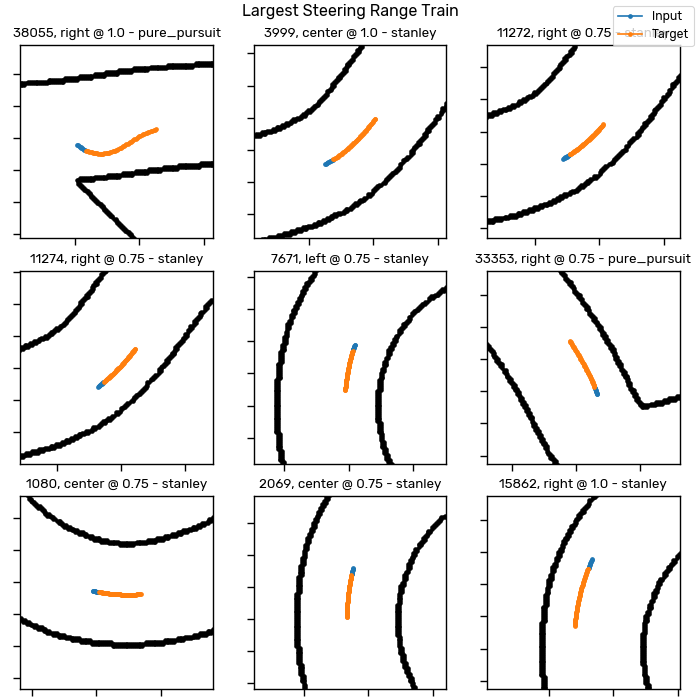

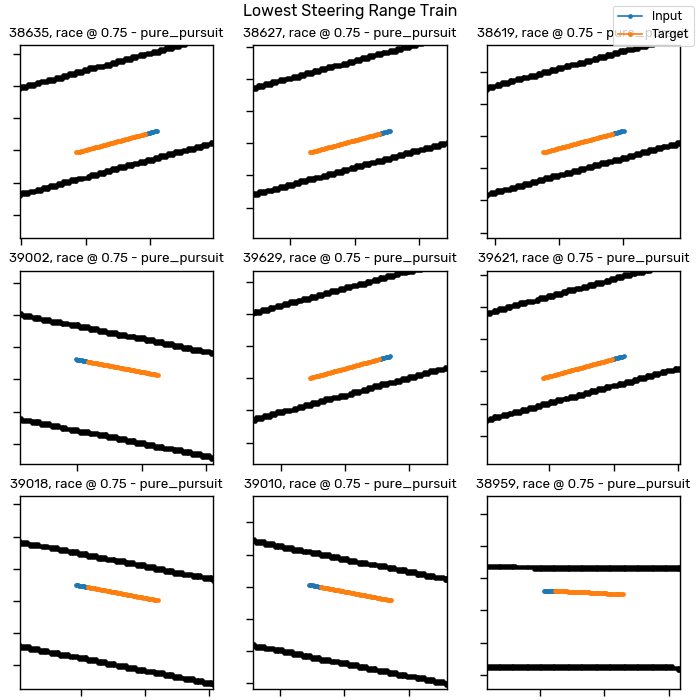

In [35]:
plt.close('all')
with plt.ioff():
    fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
    for idx, DATA_IDX in enumerate(train_frame['max_steering'].sort_values(ascending=False).index[:900:100]):
        linput, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['input_vel'][:, 0],
                                            train_frame.loc[DATA_IDX]['input_vel'][:, 1], marker='.', label="Input")
        ltarget, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['target'][:, 0],
                                            train_frame.loc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
        xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
        axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
        axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                                ylim=(ylim - 3, ylim + 3),
                                aspect=1.0,
                                adjustable='box',
                                yticklabels=[],
                                xticklabels=[])
        axs[idx // 3, idx % 3].set_title("{}, {}".format(DATA_IDX, train_frame.loc[DATA_IDX]['trace_name']))
    fig.suptitle("Largest Steering Range Train")
    fig.legend(handles=[linput, ltarget])
    fig.show()
    fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
    for idx, DATA_IDX in enumerate(train_frame['steering_range'].sort_values(ascending=True).index[:9]):
        linput, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['input_vel'][:, 0],
                                            train_frame.loc[DATA_IDX]['input_vel'][:, 1], marker='.', label="Input")
        ltarget, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['target'][:, 0],
                                            train_frame.loc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
        xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
        axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
        axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                                ylim=(ylim - 3, ylim + 3),
                                aspect=1.0,
                                adjustable='box',
                                yticklabels=[],
                                xticklabels=[])
        axs[idx // 3, idx % 3].set_title("{}, {}".format(DATA_IDX, train_frame.loc[DATA_IDX]['trace_name']))
    fig.suptitle("Lowest Steering Range Train")
    fig.legend(handles=[linput, ltarget])
    fig.show()

In [36]:
frame = val_frame
val_list = list()
val_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
val_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='left @ 0.75 - stanley'].sort_values(ascending=True).index[::6][:5]))
val_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='center @ 0.85 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
val_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 1.0 - stanley'].sort_values(ascending=False).index[::6][:5]))
val_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='left @ 0.75 - pure_pursuit'].sort_values(ascending=False).index[::6][:5]))
val_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='right @ 0.85 - stanley'].sort_values(ascending=False).index[::6][:5]))
val_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
val_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='left @ 0.75 - stanley'].sort_values(ascending=True).index[::6][:5]))
val_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='center @ 0.85 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
print(f"Val List: {val_list}")

Val List: [42537, 6231, 23888, 21645, 27858, 14731, 42980, 7037, 24535]


In [37]:
frame = train_frame
train_list = list()
train_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
train_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='left @ 0.75 - stanley'].sort_values(ascending=True).index[::6][:5]))
train_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='center @ 0.85 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
train_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 1.0 - stanley'].sort_values(ascending=False).index[::6][:5]))
train_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='left @ 0.75 - pure_pursuit'].sort_values(ascending=False).index[::6][:5]))
train_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='right @ 0.85 - stanley'].sort_values(ascending=False).index[::6][:5]))
train_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
train_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='left @ 0.75 - stanley'].sort_values(ascending=True).index[::6][:5]))
train_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='center @ 0.85 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
print(f"Train List: {train_list}")

Train List: [42086, 6219, 25331, 21680, 28354, 13329, 42689, 7588, 25676]


In [38]:
frame = test_frame
test_list = list()
test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='left @ 0.75 - stanley'].sort_values(ascending=True).index[::6][:5]))
test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='center @ 0.85 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 1.0 - stanley'].sort_values(ascending=False).index[::6][:5]))
test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='left @ 0.75 - pure_pursuit'].sort_values(ascending=False).index[::6][:5]))
test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='right @ 0.85 - stanley'].sort_values(ascending=False).index[::6][:5]))
test_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
test_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='left @ 0.75 - stanley'].sort_values(ascending=True).index[::6][:5]))
test_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='center @ 0.85 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
print(f"Test List: {test_list}")

Test List: [43226, 6908, 24000, 21670, 28247, 14169, 42737, 5876, 25405]


In [39]:
frame = test_frame[test_frame['trace_name'].apply(lambda x: True if 'race' in x else False)]
race_test_list = list()
race_test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
race_test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 0.75 - stanley'].sort_values(ascending=True).index[::6][:5]))
race_test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 0.85 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
race_test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 1.0 - stanley'].sort_values(ascending=False).index[::6][:5]))
race_test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 0.75 - pure_pursuit'].sort_values(ascending=False).index[::6][:5]))
race_test_list.append(np.random.choice(frame['avg_curvature'][frame['trace_name']=='race @ 0.85 - stanley'].sort_values(ascending=False).index[::6][:5]))
race_test_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
race_test_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='race @ 0.75 - stanley'].sort_values(ascending=True).index[::6][:5]))
race_test_list.append(np.random.choice(frame['steering_range'][frame['trace_name']=='race @ 0.85 - pure_pursuit'].sort_values(ascending=True).index[::6][:5]))
print(f"Race Test List: {race_test_list}")

Race Test List: [42378, 18229, 41608, 21551, 38352, 20272, 42039, 17109, 41694]


In [59]:
print(f"VAL_LIST = {val_list}")
print(f"TRAIN_LIST = {train_list}")
print(f"TEST_LIST = {test_list}")
print(f"RACE_TEST_LIST = {race_test_list}")

VAL_LIST = [42537, 6231, 23888, 21645, 27858, 14731, 42980, 7037, 24535]
TRAIN_LIST = [42086, 6219, 25331, 21680, 28354, 13329, 42689, 7588, 25676]
TEST_LIST = [43226, 6908, 24000, 21670, 28247, 14169, 42737, 5876, 25405]
RACE_TEST_LIST = [42378, 18229, 41608, 21551, 38352, 20272, 42039, 17109, 41694]


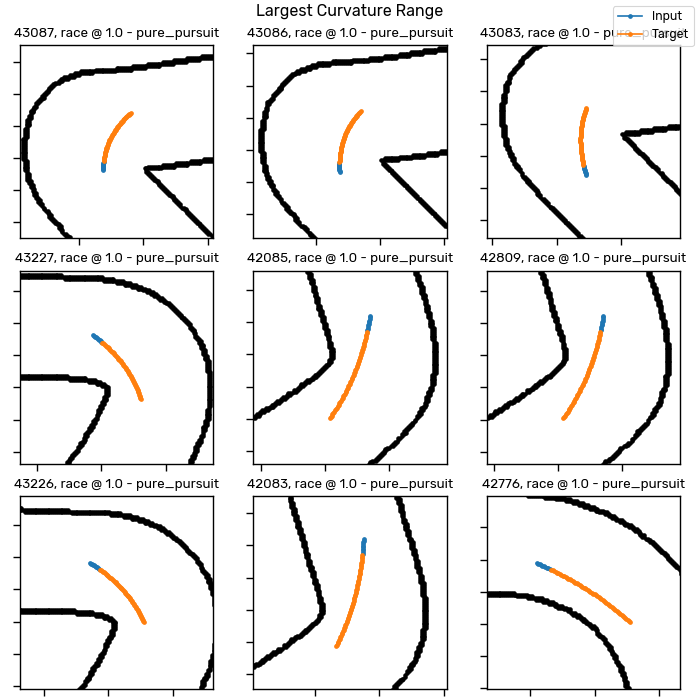

'\nfig, axs = plt.subplots(3, 3, figsize=(7, 5), dpi=100)\nfor idx, DATA_IDX in enumerate(train_frame[\'curvature_range\'].sort_values(ascending=True).index[:9]):\n    linput, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX][\'input_vel\'][:, 0],\n                                        train_frame.loc[DATA_IDX][\'input_vel\'][:, 1], marker=\'.\', label="Input")\n    ltarget, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX][\'target\'][:, 0],\n                                        train_frame.loc[DATA_IDX][\'target\'][:, 1], marker=\'.\', label="Target")\n    xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())\n    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color=\'black\')\n    axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),\n                            ylim=(ylim - 3, ylim + 3),\n                            aspect=1.0,\n                            adjustable=\'box\',\n                           

In [69]:
frame = test_frame
fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
for idx, DATA_IDX in enumerate(frame['max_curvature'][frame['trace_name']=='race @ 1.0 - pure_pursuit'].sort_values(ascending=True).index[::1][:9]):
    linput, = axs[idx // 3, idx % 3].plot(frame.loc[DATA_IDX]['input_vel'][:, 0],
                                        frame.loc[DATA_IDX]['input_vel'][:, 1], marker='.', label="Input")
    ltarget, = axs[idx // 3, idx % 3].plot(frame.loc[DATA_IDX]['target'][:, 0],
                                        frame.loc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                            ylim=(ylim - 3, ylim + 3),
                            aspect=1.0,
                            adjustable='box',
                            yticklabels=[],
                            xticklabels=[])
    axs[idx // 3, idx % 3].set_title("{}, {}".format(DATA_IDX, frame.loc[DATA_IDX]['trace_name']))
fig.suptitle("Largest Curvature Range")
fig.legend(handles=[linput, ltarget])
fig.show()
"""
fig, axs = plt.subplots(3, 3, figsize=(7, 5), dpi=100)
for idx, DATA_IDX in enumerate(train_frame['curvature_range'].sort_values(ascending=True).index[:9]):
    linput, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['input_vel'][:, 0],
                                        train_frame.loc[DATA_IDX]['input_vel'][:, 1], marker='.', label="Input")
    ltarget, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['target'][:, 0],
                                        train_frame.loc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                            ylim=(ylim - 3, ylim + 3),
                            aspect=1.0,
                            adjustable='box',
                            yticklabels=[],
                            xticklabels=[])
    axs[idx // 3, idx % 3].set_title("{}, {}".format(DATA_IDX, train_frame.loc[DATA_IDX]['trace_name']))
fig.suptitle("Smallest Curvature Range Train")
fig.legend(handles=[linput, ltarget])
fig.show()
"""

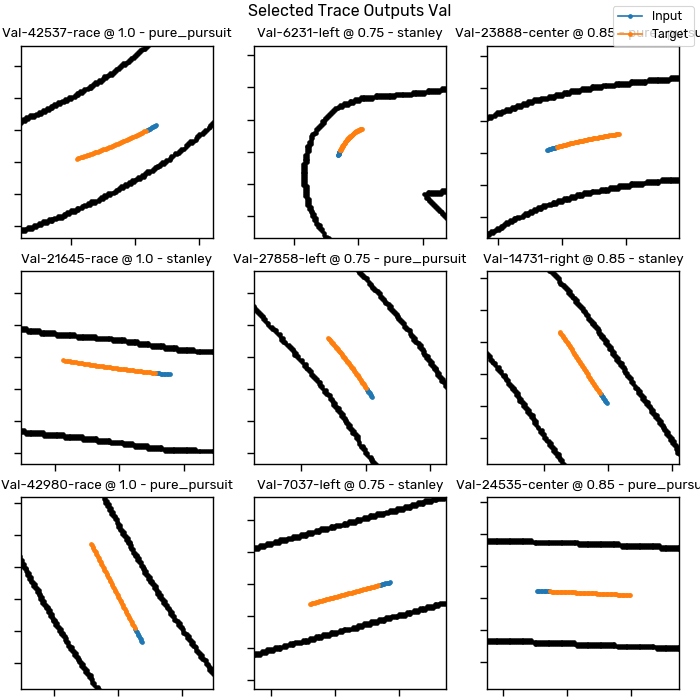

In [61]:
fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
for idx, DATA_IDX in enumerate(val_list):
    data_in_set = "Train" if DATA_IDX in train_frame.index else False
    if not data_in_set:
        data_in_set = "Test" if DATA_IDX in test_frame.index else "Val"
    dframe = dataset_frame
    linput, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['input_vel'][:,0], dframe.loc[DATA_IDX]['input_vel'][:,1], marker='.', label="Input")
    ltarget, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['target'][:,0], dframe.loc[DATA_IDX]['target'][:,1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
    axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx//3, idx%3].set(xlim=(xlim-3,xlim+3),
                        ylim=(ylim-3,ylim+3),
                        aspect=1.0,
                        adjustable='box',
                        yticklabels=[],
                        xticklabels=[])
    axs[idx//3, idx%3].set_title("{}-{}-{}".format(data_in_set, DATA_IDX, dframe.loc[DATA_IDX]['trace_name']))
fig.suptitle("Selected Trace Outputs Val")
fig.legend(handles=[linput, ltarget])
fig.show()


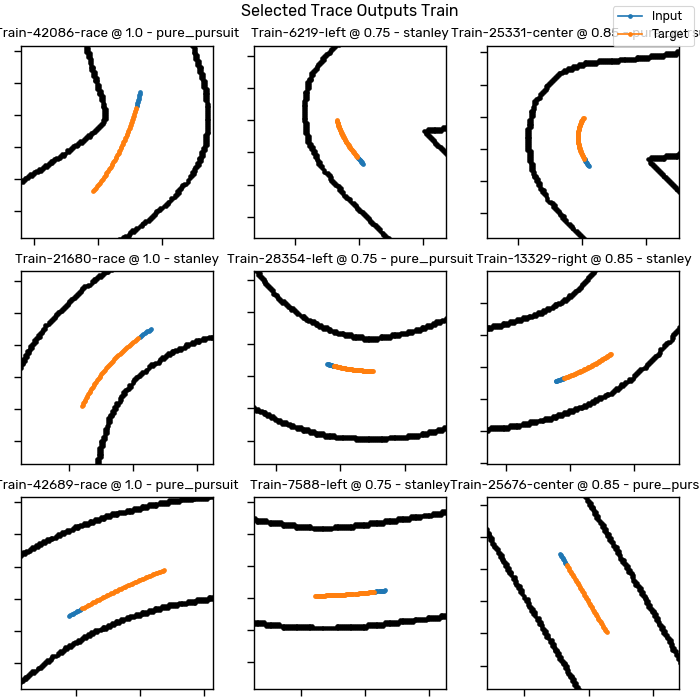

In [62]:
fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
for idx, DATA_IDX in enumerate(train_list):
    data_in_set = "Train" if DATA_IDX in train_frame.index else False
    if not data_in_set:
        data_in_set = "Test" if DATA_IDX in test_frame.index else "Val"
    dframe = dataset_frame
    linput, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['input_vel'][:,0], dframe.loc[DATA_IDX]['input_vel'][:,1], marker='.', label="Input")
    ltarget, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['target'][:,0], dframe.loc[DATA_IDX]['target'][:,1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
    axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx//3, idx%3].set(xlim=(xlim-3,xlim+3),
                        ylim=(ylim-3,ylim+3),
                        aspect=1.0,
                        adjustable='box',
                        yticklabels=[],
                        xticklabels=[])
    axs[idx//3, idx%3].set_title("{}-{}-{}".format(data_in_set, DATA_IDX, dframe.loc[DATA_IDX]['trace_name']))
fig.suptitle("Selected Trace Outputs Train")
fig.legend(handles=[linput, ltarget])
fig.show()


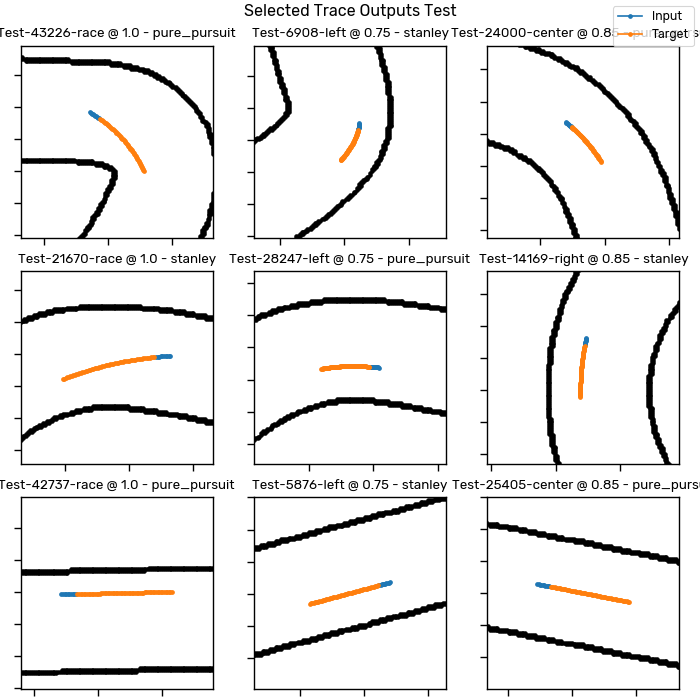

In [63]:
fig, axs = plt.subplots(3,3,figsize=(7,7), dpi=100, constrained_layout=True)
for idx, DATA_IDX in enumerate(test_list):
    data_in_set = "Train" if DATA_IDX in train_frame.index else False
    if not data_in_set:
        data_in_set = "Test" if DATA_IDX in test_frame.index else "Val"
    dframe = dataset_frame
    linput, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['input_vel'][:,0], dframe.loc[DATA_IDX]['input_vel'][:,1], marker='.', label="Input")
    ltarget, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['target'][:,0], dframe.loc[DATA_IDX]['target'][:,1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
    axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx//3, idx%3].set(xlim=(xlim-3,xlim+3),
                        ylim=(ylim-3,ylim+3),
                        aspect=1.0,
                        adjustable='box',
                        yticklabels=[],
                        xticklabels=[])
    axs[idx//3, idx%3].set_title("{}-{}-{}".format(data_in_set, DATA_IDX, dframe.loc[DATA_IDX]['trace_name']))
fig.suptitle("Selected Trace Outputs Test")
fig.legend(handles=[linput, ltarget])
fig.show()


In [54]:
train_frame.to_pickle("../../data/train_data.pkl")
val_frame.to_pickle("../../data/val_data.pkl")
test_frame.to_pickle("../../data/test_data.pkl")

In [55]:
DATA_IDX = 10
dframe.loc[DATA_IDX]['input_vel'][-3:11,:3]

array([[-39.01501  ,  15.991321 ,   5.8912554],
       [-38.994312 ,  15.983157 ,   5.8951955],
       [-38.97358  ,  15.975111 ,   5.8994827]], dtype=float32)

In [56]:
dframe.loc[DATA_IDX]['last_pose']

array([-38.97358091,  15.9751113 ,   5.89948292,   2.22292868])

In [57]:
dframe.loc[DATA_IDX]['target'][0,:3]

array([-38.95281233,  15.96720242,   5.90425745])

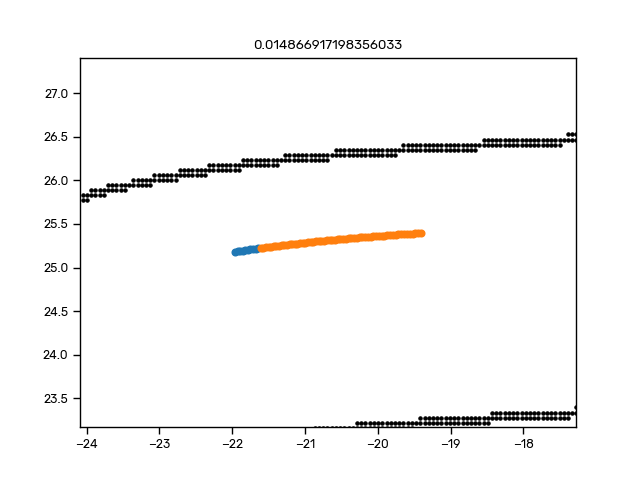

In [58]:
plt.close('all')
DATA_IDX = 8750
plt.plot(dataset_frame.iloc[DATA_IDX]['input_vel'][:,0], dataset_frame.iloc[DATA_IDX]['input_vel'][:,1], marker='o')
plt.plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='o')
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.scatter(map_x, map_y, marker=".", color='black')
plt.gca().set_xlim((xlim[0]-2,xlim[1]+2))
plt.gca().set_ylim((ylim[0]-2,ylim[1]+2))
plt.title(dataset_frame.iloc[DATA_IDX]['steering_range'])
plt.show()